In [1]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')


/Users/michaelazmy/miniforge3/envs/faiss-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Preprocessing

In [2]:
# Image preprocessing
def load_and_preprocess_image(path):
    return preprocess(Image.open(path).convert("RGB")).unsqueeze(0)

# Embedding

In [3]:
@torch.no_grad()
def get_image_embedding(image_tensor):
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize for cosine similarity
        return image_features.cpu().numpy().astype("float32")

# FAISS

In [23]:
import faiss
import numpy as np

# Assuming you have a list of image paths
image_paths = ["chair_1.png", "chair_2.png", "chair_3.png", "sofa_1.png", "table_1.png"]
embeddings = np.vstack([get_image_embedding(load_and_preprocess_image(p)) for p in image_paths])

# Create FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # Use inner product (since we normalized)
index.add(embeddings)

# Query

In [27]:
query_image = load_and_preprocess_image("chair_1.png")
query_embedding = get_image_embedding(query_image)

In [28]:
# Search top-k
k = 5
distances, indices = index.search(query_embedding, k)

In [29]:
# Show results
print("Top results:")
for rank, idx in enumerate(indices[0]):
    print(f"{rank + 1}: {image_paths[idx]} (Score: {distances[0][rank]:.4f})")

Top results:
1: chair_1.png (Score: 1.0000)
2: chair_2.png (Score: 0.6210)
3: table_1.png (Score: 0.5893)
4: chair_3.png (Score: 0.4390)
5: sofa_1.png (Score: 0.3926)


# Object Detection

In [1]:
!pip install -U torch torchvision torchaudio
!pip install -U opencv-python
!pip install -q git+https://github.com/facebookresearch/detectron2.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 438.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.22.0
    Uninstalling torchvision-0.22.0:
      Successfully uninstalled torchvision-0.22.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchaudio]2 [torchaudio]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
  DEPRECATION: Building 'detectron2' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour chang

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


/Users/michaelazmy/miniforge3/envs/faiss-env/lib/python3.10/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [41]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
target_classes = {"chair", "couch", "sofa", "dining table"}  # use COCO names

# Detect Objects

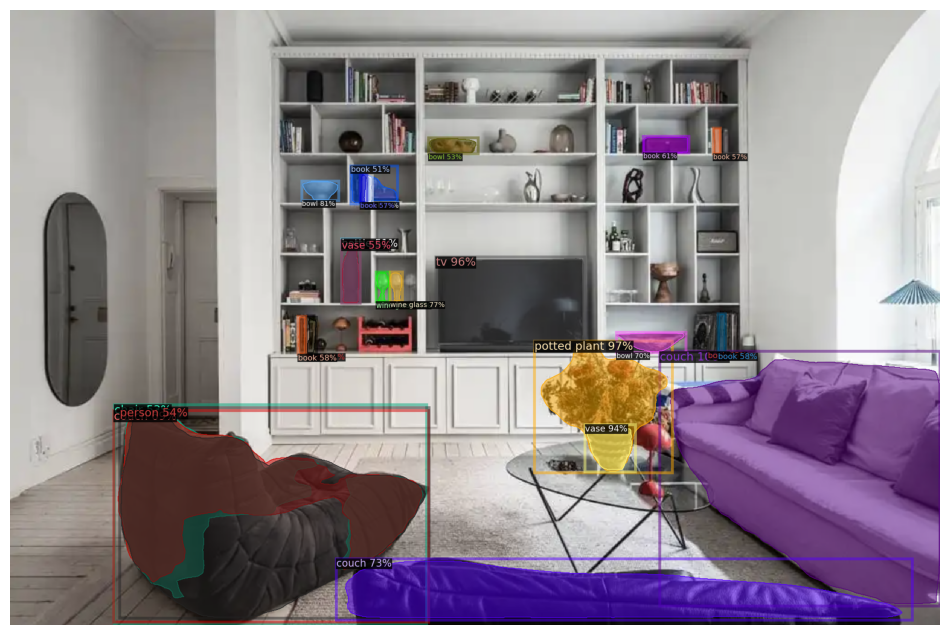

In [60]:
image = cv2.imread("./images/inspo_2.png")
outputs = predictor(image)
instances = outputs["instances"]
boxes = instances.pred_boxes.tensor.cpu().numpy()
classes = instances.pred_classes.cpu().numpy()

# Step 1: Convert BGR image to RGB for the Visualizer
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 2: Pass RGB image to Visualizer
v = Visualizer(image_rgb, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Step 3: Show directly — it's already RGB
plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

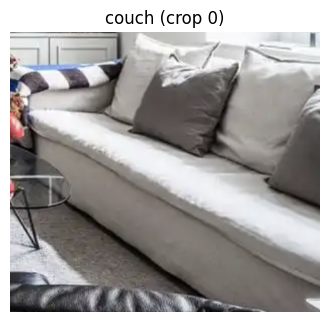

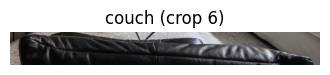

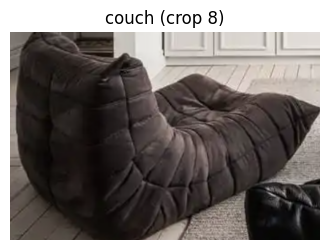

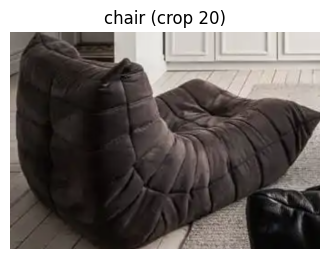

In [61]:
import matplotlib.pyplot as plt

# Define how many crops to show (e.g., first 10)
max_crops = 100
num_shown = 0

for i, box in enumerate(boxes):
    label = class_names[classes[i]]
    
    # Optional: filter specific object types
    if label not in target_classes:
        continue
    # print(label)

    x1, y1, x2, y2 = map(int, box)
    crop = image[y1:y2, x1:x2]

    # Convert BGR to RGB for matplotlib
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    # Show crop
    plt.figure(figsize=(4, 4))
    plt.imshow(crop_rgb)
    plt.title(f"{label} (crop {i})")
    plt.axis("off")
    plt.show()

    x1, y1, x2, y2 = map(int, box)
    cropped = image[y1:y2, x1:x2]
    cv2.imwrite(f"./images/crop_{label}_{i}.jpg", cropped)

    num_shown += 1
    if num_shown >= max_crops:
        break


In [ ]:
for i, box in enumerate(boxes):
    label = class_names[classes[i]]
    if label not in target_classes:
        continue
    


In [45]:
class_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']